<h1><center>Multi Layer Perceptron</center></h1>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#creating linearly seperable 2d data
def center_distance(p):
    return np.sqrt( (p[0]- 0)**2 +(p[1]-0)**2 )

def generate_dataset_nonlinear(n):
    # Generate random 2D data points
    count = 0
    x = []
    y = []

    while(count < n):
        point = np.random.rand(2,1)
        if( 0 <= center_distance(point) <= 0.1  ):
            x.append(point)
            y.append([1.0,0,0])
            count = count + 1

        if( 0.11<= center_distance(point) <= 0.15 ):
            x.append(point)
            y.append([0,1.0,0])
            count = count + 1
        if( 0.16<= center_distance(point) <= 0.18 ):
            x.append(point)
            y.append([0,0,1.0])
            count = count + 1
    x = torch.tensor(x)
    x = x.reshape(-1, 2)
    y = torch.tensor(y)
    return x,y

# Dataset Generation:
- The center_distance function calculates the Euclidean distance of a point from the origin (0, 0).
- The generate_dataset_nonlinear function generates a dataset of 2D points.
- It generates points with different classes based on their distance from the origin.
- The points within a certain range of distances are assigned specific classes.
- The function returns the input features (x) and corresponding labels (y) as PyTorch tensors.

In [3]:
def plot_data(x, y):
    # Plot the dataset based on classes in y
    colors = ['g', 'b', 'c', 'm', 'y', 'k']
    labels = [0,0,0,0,0,0,0,0]  #  to keep track of labels for each class
    plt.figure(figsize=(8, 8))
    
    for i in range(len(y)):
        cl = torch.argmax(y[i]).item()
        if (labels[cl] == 0):
            plt.scatter(x[i][0], x[i][1], color=colors[cl], label=f'Class {cl}')
        else:
            plt.scatter(x[i][0], x[i][1], color=colors[cl])
        labels[cl] = 1
        
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Dataset')
    plt.legend()
    plt.show()

# Data Plotting:
- The plot_data function visualizes the dataset.
- It uses Matplotlib to create a scatter plot of the data points, with different colors representing different classes.

/var/folders/td/d06052c13fx_0ckcn_5bft1c0000gn/T/ipykernel_52856/1812902193.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  x = torch.tensor(x)


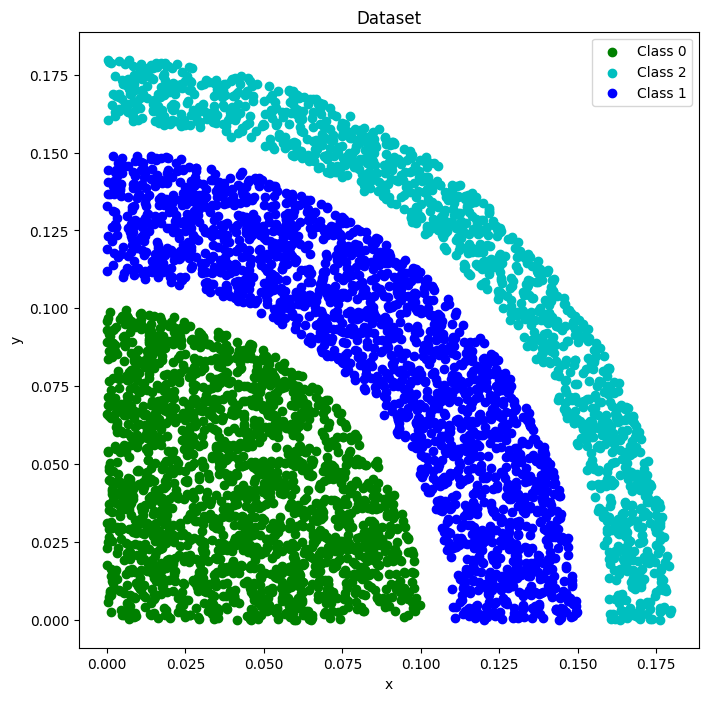

In [4]:
# Generate the nonlinear dataset
n = 5000
x_train, y_train = generate_dataset_nonlinear(n)

# Plot the generated data
plot_data(x_train, y_train)

In [5]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
         # Xavier initialization

        self.weights = []
        self.weights.append(torch.randn(hidden_sizes[0], input_size, dtype=torch.float64) / torch.sqrt(torch.tensor(input_size, dtype=torch.float64))) 
    
        self.biases = []
        self.biases.append(torch.randn(hidden_sizes[0], dtype=torch.float64))
        
        for i in range(1, len(hidden_sizes)):
            self.weights.append(torch.randn(hidden_sizes[i], hidden_sizes[i-1], dtype=torch.float64) / torch.sqrt(torch.tensor(hidden_sizes[i-1], dtype=torch.float64)))
            self.biases.append(torch.randn(hidden_sizes[i], dtype=torch.float64))
        
        self.weights.append(torch.randn(output_size, hidden_sizes[-1], dtype=torch.float64) / torch.sqrt(torch.tensor(hidden_sizes[-1], dtype=torch.float64)))
        self.biases.append(torch.randn(output_size, dtype=torch.float64))
        
        self.num_layers = len(self.weights)
        
    def forward(self, x):
        h = []  # list of post-activation
        a = []  # list of pre-activation
        
        a_temp = self.weights[0] @ x + self.biases[0]
        a.append(a_temp)
        h_temp = self.sigmoid(a_temp)
        h.append(h_temp)
    
        for i in range(1, self.num_layers - 1):
            a_temp = self.weights[i] @ h_temp + self.biases[i]
            a.append(a_temp)
            h_temp = self.sigmoid(a_temp)
            h.append(h_temp)
        
        a_temp = self.weights[-1] @ h_temp + self.biases[-1]
        a.append(a_temp)
        h_temp = self.softmax(a_temp)
        h.append(h_temp)
     
        return h, a  # last h is the output
             
    def backward(self, h, a, x, y):
        gradients_w = []
        gradients_b = []

        # Backpropagation for the output layer
        gd_wrt_a = h[-1] - y 
        # Gradient of the loss with respect to the pre-activation of the output layer

        for i in range(self.num_layers - 1, 0, -1):
            # Gradients wrt parameters
            gd_w_temp = torch.outer(gd_wrt_a, h[i-1])
            gradients_w.append(gd_w_temp)

            # Gradients wrt biases
            gradients_b.append(gd_wrt_a)

            # Gradients wrt layers below
            gd_wrt_h = self.weights[i].T @ gd_wrt_a 
            gd_wrt_a = torch.mul(gd_wrt_h, self.sigmoid_der(a[i-1]))

        gd_w_temp = torch.outer(gd_wrt_a, x)  # Gradients for the starting weights, no need to calculate a and h
        gradients_w.append(gd_w_temp)
        gradients_b.append(gd_wrt_a)

        gradients_w.reverse()
        gradients_b.reverse()

        return gradients_w, gradients_b

    def train(self, x, y, alpha, max_epoch=500, err=0.01, momentum=0.9):
        error_list = []
        epochs = 0

        velocities_w = [torch.zeros_like(w) for w in self.weights]
        velocities_b = [torch.zeros_like(b) for b in self.biases]

        for j in range(max_epoch):
            error = 0

            for k in range(len(x)):
                h, a = self.forward(x[k])
                gradients_w, gradients_b = self.backward(h, a, x[k], y[k])

                for i in range(len(self.weights)):
                    velocities_w[i] = momentum * velocities_w[i] + alpha * gradients_w[i]
                    velocities_b[i] = momentum * velocities_b[i] + alpha * gradients_b[i]
                    self.weights[i] -= velocities_w[i]
                    self.biases[i] -= velocities_b[i]

                error += -torch.sum(y[k] * torch.log(self.classifier(x[k])))
                if(j == max_epoch-1):
                    print("pred",self.classifier(x[k]))
                    print("actual",y[k])

            epochs += 1
            error_list.append(error / len(x))
            if error_list[-1] < err:
                print("Early stop")
                break

        lst = list(range(1, epochs + 1))
        plt.plot(lst, error_list)



    def classifier(self, x):
        h, a = self.forward(x)
        return h[-1]

    def test(self, x, y):
        error = 0
        y_pred = []
        for i in range(len(x)):
            temp = self.classifier(x[i])
            if torch.argmax(temp) != torch.argmax(y[i]):
                error += 1                                #employed 0-1 error in case of testing but this is not optimal for training
            z = torch.zeros_like(temp)
            z[torch.argmax(temp)] = 1
            y_pred.append(z)
        
        return (error/len(x)), y_pred
    

    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))
    
    def sigmoid_der(self,x):
        sigmoid_x = self.sigmoid(x)
        return sigmoid_x * (1 - sigmoid_x)

    def softmax(self, x):
        x = x - torch.max(x)  # for faster optimization
        exp_x = torch.exp(x)
        softmax_x = exp_x / torch.sum(exp_x)
        return softmax_x

# MLP Class
<p>The MLP (Multi-Layer Perceptron) class represents a feed-forward neural network model. It consists of an input layer, one or more hidden layers, and an output layer.</p>

* The constructor __init__ initializes the MLP model with the specified architecture: input size, hidden layer sizes, and output size.
* The weights (self.weights) and biases (self.biases) are initialized for each layer using random values. The weights connect the neurons between consecutive layers, and the biases are the thresholds for neuron activation.

<p>Xavier initialization is used in the MLP model to prevent the vanishing or exploding gradient problem during training. It ensures that the initial weights are set in a way that maintains a balanced variance of activations and gradients across layers. By using Xavier initialization, the MLP model improves the convergence and performance by avoiding extremely small or large gradients. This initialization technique plays a crucial role in training deep neural networks effectively.</p>

* The forward method performs the forward pass through the MLP model. It takes an input (x) and computes the pre-activation (a) and post-activation (h) values for each layer.
 * It starts by calculating the pre-activation for the first hidden layer using the weights and biases of the input layer.
 * The pre-activation is passed through an activation function (sigmoid) to obtain the post-activation value for the first hidden layer.This process is repeated for each subsequent hidden layer until the output layer is reached.
 * The output layer uses a softmax activation function to transform the pre-activation values into probabilities for each class.

* The backward method performs backpropagation to compute the gradients of the loss with respect to the weights and biases. It takes the post-activation values (h), pre-activation values (a), input (x), and target labels (y) as inputs.
 * Starting from the output layer, it calculates the gradient of the loss with respect to the pre-activation of each layer.
 * It then computes the gradients for the weights and biases of each layer by propagating these gradients backward through the network.
 * The gradients are calculated using the chain rule and the derivative of the activation function (sigmoid derivative).
 
* The train method trains the MLP model using gradient descent optimization with momentum. It takes the input features (x) and labels (y) for training, learning rate (alpha), maximum number of epochs (max_epoch), and an error threshold (err) as inputs.
 * It iterates over the training dataset for the specified number of epochs, updating the weights and biases based on the computed gradients.
 * The training error is calculated as the negative log-likelihood of the predicted labels compared to the target labels.
 * The training stops early if the error falls below the specified threshold (err).

* The test method evaluates the trained model on a test dataset. It takes the test input features (x) and labels (y) as inputs.
 * It calculates the misclassification error by comparing the predicted labels with the ground truth labels.
 * The misclassification error is the fraction of samples that are incorrectly classified.

Early stop


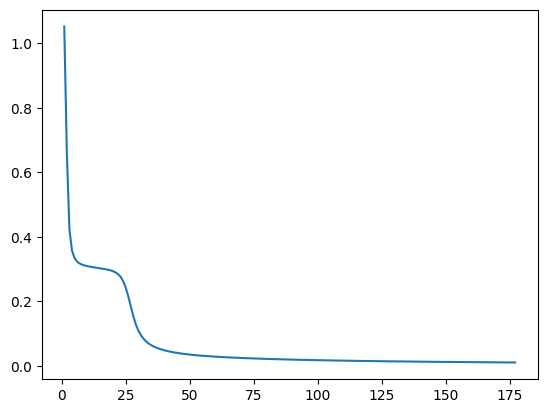

In [6]:
model = MLP(2,[4],3)
model.train(x_train,y_train,0.01,max_epoch = 200)

<p>In the given scenario, the MLP model is trained on the provided dataset (x_train and y_train) using a learning rate of 0.01 and a maximum of 200 epochs.</p>

<p>After each epoch, the training error is calculated and recorded. As the training progresses, the model updates its weights and biases based on the calculated gradients and the chosen optimization algorithm (in this case, gradient descent with momentum).</p>

<p>Initially, during the early epochs, the model experiences significant updates and the training error tends to decrease rapidly. This is because the model is learning to fit the training data and adjust its parameters to minimize the error.</p>

<p>As the training continues, the model starts to converge towards a minimum error. After around 100 iterations, the decline in the error becomes less steep, indicating that the model is approaching a saturation point. At this stage, the updates to the model's weights and biases are smaller since the model has already learned the essential patterns in the data.</p>

<p>The saturation of the plot means that further iterations have diminishing effects on reducing the error. This can happen when the model has already captured most of the relevant information from the data and reached a reasonably optimal solution. Additional iterations beyond this point may not significantly improve the model's performance and may even risk overfitting the training data.</p>

<p>Overall, the observed steady decline in the error after 100 iterations suggests that the model is learning the underlying patterns in the data and converging towards a suitable solution. It demonstrates that the model has learned to approximate the relationships between the input features and the corresponding target labels in the dataset.</p>

the testing error on this training dataset is 0.0 with 0-1 error


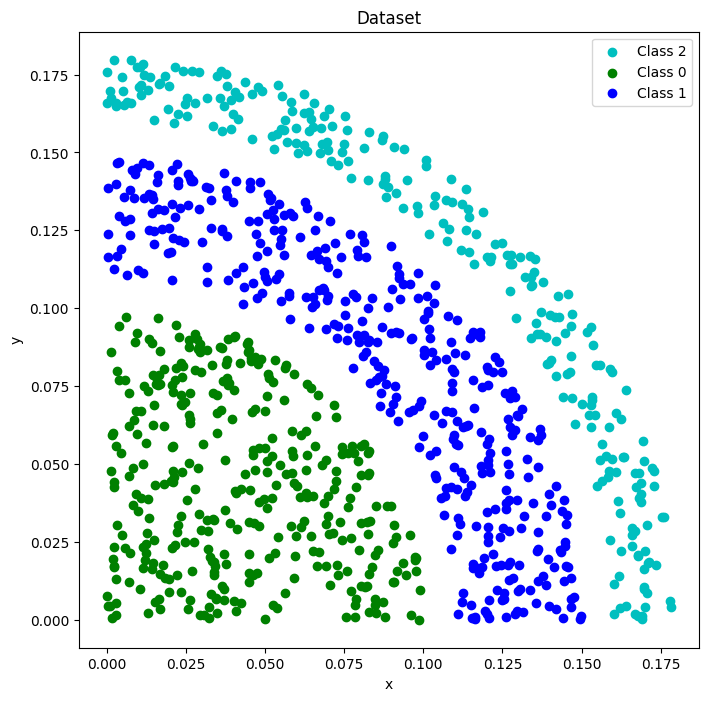

In [7]:
x_test, y_test = generate_dataset_nonlinear(1000)
error,y_pred = model.test(x_test,y_test)
print(f'the testing error on this training dataset is {error} with 0-1 error')
plot_data(x_test, y_test)

<p>In the provided code snippet, an MLP model is trained and evaluated on a test dataset. The model demonstrates its ability to learn complex transformations of the data, achieving a remarkable accuracy of 100% on the 1000-point test dataset.</p>

<p>The training process involves iterating through multiple epochs and updating the model's weights and biases using gradient descent with momentum. As the training progresses, the model learns to minimize the error between its predictions and the ground truth labels in the training dataset.</p>

<p>Once the training is completed, the model is evaluated on the separate test dataset. The testing error is calculated by comparing the predicted labels with the true labels in the test dataset. In this case, the model achieves an error of 0%, indicating perfect classification accuracy.</p>

<p>The simultaneous visualization of the test dataset and the model's predictions allows us to observe the model's performance visually. By plotting the data points with their corresponding ground truth labels and the model's predicted labels, we can assess how well the model aligns with the true data distribution.</p>

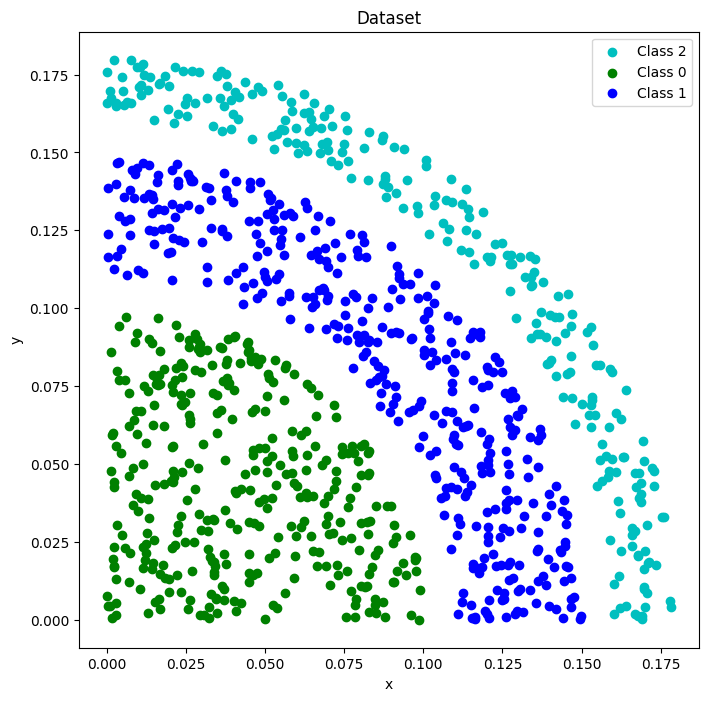

In [8]:
plot_data(x_test, y_pred)

<p>The exceptional performance achieved by the MLP model highlights its superiority over other traditional machine learning algorithms in handling complex patterns. Algorithms such as logistic regression, support vector machines (SVM), decision trees, and Naive Bayes may struggle to achieve the same level of accuracy on this particular task. MLPs, with their ability to learn hierarchical representations and capture intricate non-linear relationships, outshine these algorithms in complex data transformations. This showcases the power of deep learning and the MLP model in accurately classifying the test dataset, making it a preferred choice for such challenging tasks.</p>